<a href="https://colab.research.google.com/github/huynguyen12019/KHDLUD-k18-nhom06-entity-embedding-rossmann/blob/main/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mô tả bài toán



Bài toán **Rossmann Store Sales** nhằm mục đích dự đoán doanh số bán hàng bằng cách sử dụng dữ liệu cửa hàng, khuyến mãi và đối thủ cạnh tranh.

**Link cuộc thi:** https://www.kaggle.com/c/rossmann-store-sales/overview

**Vấn đề:** Rossmann điều hành hơn 3.000 cửa hàng thuốc tại 7 quốc gia châu Âu. Hiện tại, những người quản lý cửa hàng Rossmann được giao nhiệm vụ dự đoán doanh số hàng ngày của họ trước tối đa 6 tuần. Doanh số bán hàng của cửa hàng bị ảnh hưởng bởi nhiều yếu tố, bao gồm khuyến mãi, cạnh tranh, ngày lễ của trường và tiểu bang, thời vụ và địa phương. Với hàng nghìn nhà quản lý cá nhân dự đoán doanh số bán hàng dựa trên các trường hợp đặc biệt của họ, độ chính xác của kết quả có thể khá khác nhau. Từ đó mà cuộc thi Rossmann Store Sales được hình thành trên Kaggle với hàng nghìn team tham gia để giải quyết bài toán.


# Giải quyết bài toán

Trong đồ án này, nhóm tìm hiểu và cài đặt lại phương pháp của nhóm **Neokami Inc** đạt hạng 3 trên Private Leaderboard.

**Github:** https://github.com/entron/entity-embedding-rossmann/tree/kaggle

**Mô tả:** Giải pháp của tác giả dựa trên việc ánh xạ các biến phân loại trong một bài toán xấp xỉ hàm vào các không gian Euclide - được gọi là thực thể nhúng (entity embeddings) của các biến phân loại.

* Entity Embeddings không chỉ làm giảm mức sử dụng bộ nhớ và tăng tốc mạng neural so với one-hot encoding, nhưng quan trọng hơn là bằng cách ánh xạ các giá trị tương tự nhau trong không gian nhúng, nó tiết lộ các thuộc tính nội tại của các biến phân loại.
* Các embedding thu được từ mạng neural có khả năng tăng hiệu suất của các phương pháp học máy khi được sử dụng làm các tính năng đầu vào thay thế.

# **1. Load dữ liệu**

In [ ]:
import pickle
import csv
from random import shuffle

#### ***1.1 Tải và đánh giá dữ liệu về cửa hàng (store_data)***

In [ ]:
def csv2dicts(csvfile):
    data = []
    keys = []
    for row_index, row in enumerate(csvfile):
        if row_index == 0:
            keys = row
            print(row)
            continue
        # if row_index % 10000 == 0:
        #     print(row_index)
        data.append({key: value for key, value in zip(keys, row)})
    return data


def set_nan_as_string(data, replace_str='0'):
    for i, x in enumerate(data):
        for key, value in x.items():
            if value == '':
                x[key] = replace_str
        data[i] = x


##### Các data mà cuộc thi cung cấp

In [ ]:
train_data = "train.csv"
store_data = "store.csv"
test_data = "test.csv"

In [ ]:
with open(train_data) as csvfile:
    data = csv.reader(csvfile, delimiter=',')

    with open('train_data.pickle', 'wb') as f:
        data = csv2dicts(data)
        data = data[::-1]
        train_data = data
        pickle.dump(data, f, -1)
        # print(data[:3])

with open(test_data) as csvfile:
    data = csv.reader(csvfile, delimiter=',')
    with open('test_data.pickle', 'wb') as f:
        data = csv2dicts(data)
        test_data = data
        pickle.dump(data, f, -1)
        # print(data[0])
store_states = 'store_states.csv'
with open(store_data) as csvfile, open(store_states) as csvfile2:
    data = csv.reader(csvfile, delimiter=',')
    state_data = csv.reader(csvfile2, delimiter=',')
    with open('store_data.pickle', 'wb') as f:
        data = csv2dicts(data)
        state_data = csv2dicts(state_data)
        set_nan_as_string(data)
        for index, val in enumerate(data):
            state = state_data[index]
            val['State'] = state['State']
            data[index] = val
        store_data = data
        pickle.dump(data, f, -1)
        # print(data[:2])

['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
['Store', 'State']


##### Quan sát dữ liệu của tập train và test

In [ ]:
train_data[:2]

[{'Store': '1115',
  'DayOfWeek': '2',
  'Date': '2013-01-01',
  'Sales': '0',
  'Customers': '0',
  'Open': '0',
  'Promo': '0',
  'StateHoliday': 'a',
  'SchoolHoliday': '1'},
 {'Store': '1114',
  'DayOfWeek': '2',
  'Date': '2013-01-01',
  'Sales': '0',
  'Customers': '0',
  'Open': '0',
  'Promo': '0',
  'StateHoliday': 'a',
  'SchoolHoliday': '1'}]

- Nhận xét:
  - Store: là id của mỗi cửa hàng
  - DayofWeek: là thứ trong tuần
  - Date: là ngày bán hàng
  - Sales: là doanh thu trong ngày
  - Customers: số lượng khách hàng trong ngày
  - Open: cho biết nhà thuốc có mở cửa vào ngày đó không
  - Promo: nhà thuốc có chạy quảng cáo vào ngày đó không
  - StateHoliday: chỉ ra ngày nghỉ lễ (hầu hết các nhà thuốc sẽ đóng cửa trong những ngày này) [a = nghỉ lễ, b = lễ phục sinh, c = giáng sinh, 0 = Không]. 
  - SchoolHoliday: chỉ ra những ngày nghỉ lễ của trường có ảnh hưởng đến nhà thuốc vào ngày đấy hay là không 

##### Quan sát dữ liệu tập store_data

In [ ]:
store_data[:2]

[{'Store': '1',
  'StoreType': 'c',
  'Assortment': 'a',
  'CompetitionDistance': '1270',
  'CompetitionOpenSinceMonth': '9',
  'CompetitionOpenSinceYear': '2008',
  'Promo2': '0',
  'Promo2SinceWeek': '0',
  'Promo2SinceYear': '0',
  'PromoInterval': '0',
  'State': 'HE'},
 {'Store': '2',
  'StoreType': 'a',
  'Assortment': 'a',
  'CompetitionDistance': '570',
  'CompetitionOpenSinceMonth': '11',
  'CompetitionOpenSinceYear': '2007',
  'Promo2': '1',
  'Promo2SinceWeek': '13',
  'Promo2SinceYear': '2010',
  'PromoInterval': 'Jan,Apr,Jul,Oct',
  'State': 'TH'}]

- Nhận xét:
  - Store: là id của mỗi cửa hàng
  - StoreType: mô loại hình nhà thuốc: a, b, c, d 
  - Assortment: cấp độ phân loại nhà thuốc: [a = basic, b = extra, c = extended]
  - CompetitionDistance: khoảng cách đến nhà thuốc đối thủ gần nhất.
  - CompetitionOpenSinceMonth: thời gian mà nhà thuốc đối thủ trên bắt đầu hoạt động (tháng).
  - CompetitionOpenSinceYear: thời gian mà nhà thuốc đối thủ trên bắt đầu hoạt động (năm).
  - Promo: chỉ ra liệu nhà thuốc có đang chạy quảng bá trong ngày đấy hay không. 
  - Promo2 -  chương trình quảng bá tiếp theo mà một số nhà thuốc tham gia: [0 = không tham gia, 1 = tham gia] 
  - Promo2Since[Year/Week] - thời điểm mà nhà thuốc bắt đầu tham gia hoạt động Promo2. 
  - PromoInterval - chỉ những tháng mà sự kiện Promo2 diễn ra trong năm. 

#### ***1.2 Tải và đánh giá dữ liệu về thời tiết***

Các tập dữ liệu store_states, weather và google trend được chia sẻ trong nhóm của cuộc thi bởi dune_dweller, MCFG và Tobias Wolfanger

##### Danh sách các khu vực thời tiết (weather)

In [ ]:
import os
f = []
for _,_,filenames in os.walk("./weather/"):
    print([i[:-4] for i in filenames])
    break

['BadenWuerttemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen', 'Hamburg', 'Hessen', 'MecklenburgVorpommern', 'Niedersachsen', 'NordrheinWestfalen', 'RheinlandPfalz', 'Saarland', 'Sachsen', 'SachsenAnhalt', 'SchleswigHolstein', 'Thueringen']


##### Quan sát data của weather

In [ ]:
data_weather = []
with open('./weather/BadenWuerttemberg.csv', 'r') as csvfile:
        daily_weather = csv.reader(csvfile, delimiter=';')
        for row_index, one_day in enumerate(daily_weather):
                data_weather.append(one_day)


In [ ]:
print(data_weather[0], end='\n\n')
print(data_weather[1], end='\n\n')
print(data_weather[2])

['Date', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa', 'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h', 'Precipitationmm', 'CloudCover', 'Events', 'WindDirDegrees']

['2013-01-01', '8', '3', '-2', '3', '1', '-3', '93', '80', '51', '1016', '1011', '1008', '31', '12', '10', '23', '6', '42', '0.25', '6', 'Fog-Rain', '228']

['2013-01-02', '6', '3', '-1', '3', '-1', '-3', '93', '77', '52', '1033', '1024', '1016', '31', '10', '10', '19', '10', 'NA', '0', '4', 'Rain', '248']


##### Danh sách các dạng thời tiết

In [ ]:
event_list = ['', 'Fog-Rain', 'Fog-Snow', 'Fog-Thunderstorm',
                  'Rain-Snow-Hail-Thunderstorm', 'Rain-Snow', 'Rain-Snow-Hail',
                  'Fog-Rain-Hail', 'Fog', 'Fog-Rain-Hail-Thunderstorm', 'Fog-Snow-Hail',
                  'Rain-Hail', 'Rain-Hail-Thunderstorm', 'Fog-Rain-Snow', 'Rain-Thunderstorm',
                  'Fog-Rain-Snow-Hail', 'Rain', 'Thunderstorm', 'Snow-Hail',
                  'Rain-Snow-Thunderstorm', 'Snow', 'Fog-Rain-Thunderstorm']
print(event_list)

['', 'Fog-Rain', 'Fog-Snow', 'Fog-Thunderstorm', 'Rain-Snow-Hail-Thunderstorm', 'Rain-Snow', 'Rain-Snow-Hail', 'Fog-Rain-Hail', 'Fog', 'Fog-Rain-Hail-Thunderstorm', 'Fog-Snow-Hail', 'Rain-Hail', 'Rain-Hail-Thunderstorm', 'Fog-Rain-Snow', 'Rain-Thunderstorm', 'Fog-Rain-Snow-Hail', 'Rain', 'Thunderstorm', 'Snow-Hail', 'Rain-Snow-Thunderstorm', 'Snow', 'Fog-Rain-Thunderstorm']


In [ ]:
import glob
def event2int(event):
    # chuyển các thông tin về các kiểu thời tiết sang dạng int
    return event_list.index(event)


def states_names_to_abbreviation(state_name):
    # chuyển thành tên viết tắt
    d = {}
    d['BadenWuerttemberg'] = 'BW'
    d['Bayern'] = 'BY'
    d['Berlin'] = 'BE'
    d['Brandenburg'] = 'BB'
    d['Bremen'] = 'HB'
    d['Hamburg'] = 'HH'
    d['Hessen'] = 'HE'
    d['MecklenburgVorpommern'] = 'MV'
    d['Niedersachsen'] = 'HB,NI'
    d['NordrheinWestfalen'] = 'NW'
    d['RheinlandPfalz'] = 'RP'
    d['Saarland'] = 'SL'
    d['Sachsen'] = 'SN'
    d['SachsenAnhalt'] = 'ST'
    d['SchleswigHolstein'] = 'SH'
    d['Thueringen'] = 'TH'

    return d[state_name]


csv_location = 'weather'
german_states_weather = glob.glob(csv_location + '/*.csv')
weather = {}
temp_a = []
temp_b = []
temp_c = []
events = []
for one_state in german_states_weather:
    state_name = os.path.splitext(os.path.basename(one_state))[0]
    state_code = states_names_to_abbreviation(state_name)
    with open(one_state, 'r') as csvfile:
        daily_weather = csv.reader(csvfile, delimiter=';')
        for row_index, one_day in enumerate(daily_weather):
            if row_index == 0:
                continue
            date = one_day[0]
            key = (state_code, date)
            temp_a.append(int(one_day[1]))
            temp_b.append(int(one_day[2]))
            temp_c.append(int(one_day[3]))
            temperature = [int(one_day[1]), int(one_day[2]), int(one_day[3])] # 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC'
            temperature = [(x - 10) / 30 for x in temperature]  # normalize
            humidity = [int(one_day[7]), int(one_day[8]), int(one_day[9])] # 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity'
            humidity = [(x - 50) / 50 for x in humidity]  # normalize
            wind = [int(one_day[16]) / 50, int(one_day[17]) / 30] # 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h'
            if one_day[20] == 'NA':
                cloud = [0]
            else:
                cloud = [int(one_day[20])]
            event = [event2int(one_day[21])]
            weather[key] = temperature + humidity + wind + cloud + event
            events.append(one_day[21])
with open('weather.pickle', 'wb') as f:
    pickle.dump(weather, f, -1)

##### Mean của nhiệt độ

In [ ]:
import numpy as np
(np.mean(temp_c) + np.mean(temp_a) + np.mean(temp_b))/3

10.410690235690234

##### Dữ liệu thời tiết sau khi đọc và chuyển đổi

In [ ]:
print(list(weather.items())[0])
print(list(weather.items())[1])

(('BW', '2013-01-01'), [-0.06666666666666667, -0.23333333333333334, -0.4, 0.86, 0.6, 0.02, 0.46, 0.2, 6, 1])
(('BW', '2013-01-02'), [-0.13333333333333333, -0.23333333333333334, -0.36666666666666664, 0.86, 0.54, 0.04, 0.38, 0.3333333333333333, 4, 16])


#### ***1.3 Tải và dánh giá dữ liệu googletrend***
Trend of certain google keywords over time, found by users to correlate well w/ given data

In [ ]:
from datetime import datetime

##### Danh sách các tập tin googletrend

In [ ]:
google_trend_files

['weather\\BadenWuerttemberg.csv',
 'weather\\Bayern.csv',
 'weather\\Berlin.csv',
 'weather\\Brandenburg.csv',
 'weather\\Bremen.csv',
 'weather\\Hamburg.csv',
 'weather\\Hessen.csv',
 'weather\\MecklenburgVorpommern.csv',
 'weather\\Niedersachsen.csv',
 'weather\\NordrheinWestfalen.csv',
 'weather\\RheinlandPfalz.csv',
 'weather\\Saarland.csv',
 'weather\\Sachsen.csv',
 'weather\\SachsenAnhalt.csv',
 'weather\\SchleswigHolstein.csv',
 'weather\\Thueringen.csv']

##### Một vài data mẫu

In [ ]:
one_state = 'googletrend\\Rossmann_DE.csv'
data_weather = []
with open(one_state, 'r') as csvfile:
        trends = csv.reader(csvfile, delimiter=',')
        for row, trend in enumerate(trends):
                data_weather.append(trend)
print(data_weather[0])
print(data_weather[1])
print(data_weather[2])

['Woche', 'Dez. 2012 - Sep. 2015']
['2012-12-02 - 2012-12-08', '77']
['2012-12-09 - 2012-12-15', '76']


In [ ]:
csv_location = 'googletrend'
google_trend_files = glob.glob(csv_location + '/*.csv')

google_trend = {}

for one_state in google_trend_files:
    state = os.path.splitext(os.path.basename(one_state))[0]
    state_code = state[-2:]
    if state_code == 'NI':
        state_code = 'HB,NI'
    print(state_code)
    with open(one_state, 'r') as csvfile:
        trends = csv.reader(csvfile, delimiter=',')
        for row, trend in enumerate(trends):
            if row == 0:
                    continue
            # The sata is represented from Sunday till Saturday - take Saturday and check the week number
            trend_value = int(trend[1])
            end_day_of_range = trend[0].split(' - ')[1]
            dt = datetime.strptime(end_day_of_range, '%Y-%m-%d')
            year = dt.year
            month = dt.month
            day = dt.day
            week_of_year = dt.isocalendar()[1]

            key = (state_code, year, week_of_year)
            google_trend[key] = trend_value / 100

with open('google_trends.pickle', 'wb') as f:
    pickle.dump(google_trend, f, -1)
    print(len(google_trend))


DE
BE
BW
BY
HE
HH
HB,NI
NW
RP
SH
SL
SN
ST
TH
2072


##### Dữ liệu google trend sau khi load và xử lí

In [ ]:
list(google_trend.items())[:2]

[(('DE', 2012, 49), 0.77), (('DE', 2012, 50), 0.76)]

#### ***1.4 Prepare features***

In [ ]:
import pickle
from datetime import datetime
from isoweek import Week
import math


with open('train_data.pickle', 'rb') as f:
    train_data = pickle.load(f)
    num_records = len(train_data)
with open('test_data.pickle', 'rb') as f:
    test_data = pickle.load(f)
with open('store_data.pickle', 'rb') as f:
    store_data = pickle.load(f)
with open('weather.pickle', 'rb') as f:
    weather = pickle.load(f)
with open('fb.pickle', 'rb') as f:
    fb = pickle.load(f)
with open('google_trends.pickle', 'rb') as f:
    googletrend = pickle.load(f)


def abc2int(char):
    # holiday state
    d = {'0': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4}
    return d[char]


def state2int(state):
    # chuyển state thành int
    d = {'HB,NI': 0, 'HH': 1, 'TH': 2, 'RP': 3, 'ST': 4, 'BW': 5,
         'SN': 6, 'BE': 7, 'HE': 8, 'SH': 9, 'BY': 10, 'NW': 11}
    return d[state]


def PromoInterval2int(promointerval):
    char = promointerval[0]
    d = {'0': 0, 'J': 1, 'F': 2, 'M': 3}
    return d[char]


def hasCompetitionmonths(date, CompetitionOpenSinceYear, CompetitionOpenSinceMonth):
    if CompetitionOpenSinceYear == 0:
        return 0
    dt_competition_open = datetime(year=CompetitionOpenSinceYear,
                                   month=CompetitionOpenSinceMonth,
                                   day=15)
    months_since_competition = (date - dt_competition_open).days // 30
    if months_since_competition < 0:
        return 0
    return min(months_since_competition, 24)


def hasPromo2weeks(date, Promo2SinceYear, Promo2SinceWeek):
    if Promo2SinceYear == 0:
        return 0
    start_promo2 = Week(Promo2SinceYear, Promo2SinceWeek).monday()
    weeks_since_promo2 = (date.date() - start_promo2).days // 7
    if weeks_since_promo2 < 0:
        return 0
    return min(weeks_since_promo2, 25)


def latest_promo2_months(date, promointerval, Promo2SinceYear, Promo2SinceWeek):
    if not hasPromo2weeks(date, Promo2SinceYear, Promo2SinceWeek):
        return 0
    promo2int = PromoInterval2int(promointerval)
    if promo2int == 0:
        return 0

    if date.month < promo2int:
        latest_promo2_start_year = date.year - 1
        latest_promo2_start_month = promo2int + 12 - 3
    else:
        latest_promo2_start_year = date.year
        latest_promo2_start_month = ((date.month - promo2int) // 3) * 3 + promo2int

    latest_promo2_start_day = datetime(year=latest_promo2_start_year,
                                       month=latest_promo2_start_month,
                                       day=1)
    weeks_since_latest_promo2 = (date - latest_promo2_start_day).days // 30
    return weeks_since_latest_promo2


def feature_list(record):
    dt = datetime.strptime(record['Date'], '%Y-%m-%d')
    store_index = int(record['Store'])
    year = dt.year
    month = dt.month
    day = dt.day
    week_of_year = dt.isocalendar()[1]
    day_of_week = int(record['DayOfWeek'])
    try:
        store_open = int(record['Open'])
    except:
        store_open = 1
    state_holiday = abc2int(record['StateHoliday'])
    school_holiday = int(record['SchoolHoliday'])
    # num_customers = int(record['Customers'])
    promo = int(record['Promo'])
    try:
        distance = int(store_data[store_index - 1]['CompetitionDistance'])
    except:
        distance = 0
    has_competition_for_months = hasCompetitionmonths(dt,
                                                      int(store_data[store_index - 1]['CompetitionOpenSinceYear']),
                                                      int(store_data[store_index - 1]['CompetitionOpenSinceMonth']))

    has_promo2_for_weeks = hasPromo2weeks(dt,
                                          int(store_data[store_index - 1]['Promo2SinceYear']),
                                          int(store_data[store_index - 1]['Promo2SinceWeek']))

    latest_promo2_for_months = latest_promo2_months(dt,
                                                    store_data[store_index - 1]['PromoInterval'],
                                                    int(store_data[store_index - 1]['Promo2SinceYear']),
                                                    int(store_data[store_index - 1]['Promo2SinceWeek']))
    weather_key = (store_data[store_index - 1]['State'], record['Date'])
    fb_key = (store_index, record['Date'])
    google_trend_key_DE = ('DE', year, week_of_year)
    google_trend_key_state = (store_data[store_index - 1]['State'], year, week_of_year)
    return [store_open,
            store_index,
            day_of_week,
            promo,
            year,
            month,
            day,
            state_holiday,
            school_holiday,
            has_competition_for_months,
            has_promo2_for_weeks,
            latest_promo2_for_months,
            math.log(distance + 1) / 10,
            abc2int(store_data[store_index - 1]['StoreType']),
            abc2int(store_data[store_index - 1]['Assortment']),
            PromoInterval2int(store_data[store_index - 1]['PromoInterval']),
            int(store_data[store_index - 1]['CompetitionOpenSinceYear']),
            int(store_data[store_index - 1]['Promo2SinceYear']),
            state2int(store_data[store_index - 1]['State']),
            week_of_year,
            ] + weather[weather_key] + [int(el) for el in fb[fb_key]] + [googletrend[google_trend_key_DE], googletrend[google_trend_key_state]]


train_data_X = []
train_data_y = []
for record in train_data:
    if record['Sales'] != '0' and record['Open'] != '':
        fl = feature_list(record)
        train_data_X.append(fl)
        train_data_y.append(int(record['Sales']))
print("Number of train datapoints: ", len(train_data_y))

test_data_X = []
for record in test_data:
    fl = feature_list(record)
    test_data_X.append(fl)
print("Number of test datapoints: ", len(test_data_X))

print(min(train_data_y), max(train_data_y))


with open('feature_train_data.pickle', 'wb') as f:
    pickle.dump((train_data_X, train_data_y), f, -1)
    print(train_data_X[0], train_data_y[0])

with open('feature_test_data.pickle', 'wb') as f:
    pickle.dump(test_data_X, f, -1)


Number of train datapoints:  844338
Number of test datapoints:  41088
46 41551
[1, 1097, 2, 0, 2013, 1, 1, 1, 1, 24, 0, 0, 0.6580639137284949, 2, 2, 0, 2002, 0, 3, 1, -0.06666666666666667, -0.13333333333333333, -0.2, 0.84, 0.5, 0.18, 0.52, 0.6333333333333333, 8, 16, 6, 8, 8, 8, 0, 0, 1, 8, 0.61, 0.36] 5961


# **2. Models**

In [ ]:
class Model(object):

    def __init__(self, train_ratio):
        self.train_ratio = train_ratio
        self.__load_data()

    def evaluate(self):
        if self.train_ratio == 1:
            return 0
        total_sqe = 0
        num_real_test = 0
        for record, sales in zip(self.X_val, self.y_val):
            if sales == 0:
                continue
            guessed_sales = self.guess(record)
            sqe = ((sales - guessed_sales) / sales) ** 2
            total_sqe += sqe
            num_real_test += 1
        result = math.sqrt(total_sqe / num_real_test)
        return result

    def __load_data(self):
        f = open('feature_train_data.pickle', 'rb')
        (self.X, self.y) = pickle.load(f)
        self.X = numpy.array(self.X)
        self.y = numpy.array(self.y)
        self.num_records = len(self.X)
        self.train_size = int(self.train_ratio * self.num_records)
        self.test_size = self.num_records - self.train_size
        self.X, self.X_val = self.X[:self.train_size], self.X[self.train_size:]
        self.y, self.y_val = self.y[:self.train_size], self.y[self.train_size:]


class NN_with_EntityEmbedding(Model):

    def __init__(self, train_ratio):
        super().__init__(train_ratio)
        self.build_preprocessor(self.X)
        self.nb_epoch = 20
        self.checkpointer = ModelCheckpoint(filepath="best_model_weights.hdf5", verbose=1, save_best_only=True)
        self.max_log_y = numpy.max(numpy.log(self.y))
        self.min_log_y = numpy.min(numpy.log(self.y))
        self.__build_keras_model()
        self.fit()

    def build_preprocessor(self, X):
        X_list = split_features(X)
        # Google trend de
        self.gt_de_enc = StandardScaler()
        self.gt_de_enc.fit(X_list[32])
        # Google trend state
        self.gt_state_enc = StandardScaler()
        self.gt_state_enc.fit(X_list[33])

    def preprocessing(self, X):
        X_list = split_features(X)
        X_list[32] = self.gt_de_enc.transform(X_list[32])
        X_list[33] = self.gt_state_enc.transform(X_list[33])
        return X_list

    def __build_keras_model(self):
        models = []

        model_store = Sequential()
        model_store.add(Embedding(1115, 50, input_length=1))
        # model_store.add(Reshape(target_shape=(50,)))
        model_store.add(Reshape(target_shape=(50,)))
        models.append(model_store)

        model_dow = Sequential()
        model_dow.add(Embedding(7, 6, input_length=1))
        model_dow.add(Reshape(target_shape=(6,)))
        models.append(model_dow)

        model_promo = Sequential()
        model_promo.add(Dense(1, input_dim=1))
        models.append(model_promo)

        model_year = Sequential()
        model_year.add(Embedding(3, 2, input_length=1))
        model_year.add(Reshape(target_shape=(2,)))
        models.append(model_year)

        model_month = Sequential()
        model_month.add(Embedding(12, 6, input_length=1))
        model_month.add(Reshape(target_shape=(6,)))
        models.append(model_month)

        model_day = Sequential()
        model_day.add(Embedding(31, 10, input_length=1))
        model_day.add(Reshape(target_shape=(10,)))
        models.append(model_day)

        model_stateholiday = Sequential()
        model_stateholiday.add(Embedding(4, 3, input_length=1))
        model_stateholiday.add(Reshape(target_shape=(3,)))
        models.append(model_stateholiday)

        model_school = Sequential()
        model_school.add(Dense(1, input_dim=1))
        models.append(model_school)

        model_competemonths = Sequential()
        model_competemonths.add(Embedding(25, 2, input_length=1))
        model_competemonths.add(Reshape(target_shape=(2,)))
        models.append(model_competemonths)

        model_promo2weeks = Sequential()
        model_promo2weeks.add(Embedding(26, 1, input_length=1))
        model_promo2weeks.add(Reshape(target_shape=(1,)))
        models.append(model_promo2weeks)

        model_lastestpromo2months = Sequential()
        model_lastestpromo2months.add(Embedding(4, 1, input_length=1))
        model_lastestpromo2months.add(Reshape(target_shape=(1,)))
        models.append(model_lastestpromo2months)

        model_distance = Sequential()
        model_distance.add(Dense(1, input_dim=1))
        models.append(model_distance)

        model_storetype = Sequential()
        model_storetype.add(Embedding(5, 2, input_length=1))
        model_storetype.add(Reshape(target_shape=(2,)))
        models.append(model_storetype)

        model_assortment = Sequential()
        model_assortment.add(Embedding(4, 3, input_length=1))
        model_assortment.add(Reshape(target_shape=(3,)))
        models.append(model_assortment)

        model_promointerval = Sequential()
        model_promointerval.add(Embedding(4, 3, input_length=1))
        model_promointerval.add(Reshape(target_shape=(3,)))
        models.append(model_promointerval)

        model_competyear = Sequential()
        model_competyear.add(Embedding(18, 4, input_length=1))
        model_competyear.add(Reshape(target_shape=(4,)))
        models.append(model_competyear)

        model_promotyear = Sequential()
        model_promotyear.add(Embedding(8, 4, input_length=1))
        model_promotyear.add(Reshape(target_shape=(4,)))
        models.append(model_promotyear)

        model_germanstate = Sequential()
        model_germanstate.add(Embedding(12, 6, input_length=1))
        model_germanstate.add(Reshape(target_shape=(6,)))
        models.append(model_germanstate)

        model_woy = Sequential()
        model_woy.add(Embedding(53, 2, input_length=1))
        model_woy.add(Reshape(target_shape=(2,)))
        models.append(model_woy)

        model_temperature = Sequential()
        model_temperature.add(Dense(3, input_dim=3))
        models.append(model_temperature)

        model_humidity = Sequential()
        model_humidity.add(Dense(3, input_dim=3))
        models.append(model_humidity)

        model_wind = Sequential()
        model_wind.add(Dense(2, input_dim=2))
        models.append(model_wind)

        model_cloud = Sequential()
        model_cloud.add(Dense(1, input_dim=1))
        models.append(model_cloud)

        model_weatherevent = Sequential()
        model_weatherevent.add(Embedding(22, 4, input_length=1))
        model_weatherevent.add(Reshape(target_shape=(4,)))
        models.append(model_weatherevent)

        model_promo_forward = Sequential()
        model_promo_forward.add(Embedding(8, 1, input_length=1))
        model_promo_forward.add(Reshape(target_shape=(1,)))
        models.append(model_promo_forward)

        model_promo_backward = Sequential()
        model_promo_backward.add(Embedding(8, 1, input_length=1))
        model_promo_backward.add(Reshape(target_shape=(1,)))
        models.append(model_promo_backward)

        model_stateholiday_forward = Sequential()
        model_stateholiday_forward.add(Embedding(8, 1, input_length=1))
        model_stateholiday_forward.add(Reshape(target_shape=(1,)))
        models.append(model_stateholiday_forward)

        model_sateholiday_backward = Sequential()
        model_sateholiday_backward.add(Embedding(8, 1, input_length=1))
        model_sateholiday_backward.add(Reshape(target_shape=(1,)))
        models.append(model_sateholiday_backward)

        model_stateholiday_count_forward = Sequential()
        model_stateholiday_count_forward.add(Embedding(3, 1, input_length=1))
        model_stateholiday_count_forward.add(Reshape(target_shape=(1,)))
        models.append(model_stateholiday_count_forward)

        model_stateholiday_count_backward = Sequential()
        model_stateholiday_count_backward.add(Embedding(3, 1, input_length=1))
        model_stateholiday_count_backward.add(Reshape(target_shape=(1,)))
        models.append(model_stateholiday_count_backward)

        model_schoolholiday_forward = Sequential()
        model_schoolholiday_forward.add(Embedding(8, 1, input_length=1))
        model_schoolholiday_forward.add(Reshape(target_shape=(1,)))
        models.append(model_schoolholiday_forward)

        model_schoolholiday_backward = Sequential()
        model_schoolholiday_backward.add(Embedding(8, 1, input_length=1))
        model_schoolholiday_backward.add(Reshape(target_shape=(1,)))
        models.append(model_schoolholiday_backward)

        model_googletrend_de = Sequential()
        model_googletrend_de.add(Dense(1, input_dim=1))
        models.append(model_googletrend_de)

        model_googletrend_state = Sequential()
        model_googletrend_state.add(Dense(1, input_dim=1))
        models.append(model_googletrend_state)

        # model_weather = Sequential()
        # model_weather.add(Merge([model_temperature, model_humidity, model_wind, model_weatherevent], mode='concat'))
        # model_weather.add(Dense(1))
        # model_weather.add(Activation('relu'))
        # models.append(model_weather)

        self.model = Sequential()
        self.model.add(Merge(models, mode='concat'))
        self.model.add(Dropout(0.02))
        self.model.add(Dense(1000, init='uniform'))
        self.model.add(Activation('relu'))
        self.model.add(Dense(500, init='uniform'))
        self.model.add(Activation('relu'))
        self.model.add(Dense(1))
        self.model.add(Activation('sigmoid'))

        self.model.compile(loss='mean_absolute_error', optimizer='adam')

    def _val_for_fit(self, val):
        val = numpy.log(val) / self.max_log_y
        return val

    def _val_for_pred(self, val):
        return numpy.exp(val * self.max_log_y)

    def fit(self):
        if self.train_ratio < 1:
            self.model.fit(self.preprocessing(self.X), self._val_for_fit(self.y),
                           validation_data=(self.preprocessing(self.X_val), self._val_for_fit(self.y_val)),
                           nb_epoch=self.nb_epoch, batch_size=128,
                           # callbacks=[self.checkpointer],
                           )
            # self.model.load_weights('best_model_weights.hdf5')
            print("Result on validation data: ", self.evaluate())
        else:
            self.model.fit(self.preprocessing(self.X), self._val_for_fit(self.y),
                           nb_epoch=self.nb_epoch, batch_size=128)

    def guess(self, feature):
        feature = numpy.array(feature).reshape(1, -1)
        return self._val_for_pred(self.model.predict(self.preprocessing(feature)))[0][0]


# **3. Test model**

Tác giả sử dụng số lượng các mạng NN là `num_network = 10` và `train_ratio = 1`

In [ ]:
# from models_temp import NN_with_EntityEmbedding
import math
import numpy
import sys
# import pickle
import pickle5 as pickle
sys.setrecursionlimit(10000)

num_networks = 1
train_ratio = 0.97

with open('feature_train_data.pickle', 'rb') as f:
    X, y = pickle.load(f)
    num_records = len(y)

models = []
for i in range(num_networks):
    print("Fitting NN_with_EntityEmbedding...")
    models.append(NN_with_EntityEmbedding(train_ratio))

with open('models.pickle', 'wb') as f:
    pickle.dump(models, f, -1)


def evaluate_models(models, num_records):
    model0 = models[0]
    total_sqe = 0
    num_real_test = 0
    if model0.train_ratio == 1:
        return 0
    for i in range(model0.train_size, num_records):
        record = X[i]
        sales = y[i]
        if sales == 0:
            continue
        guessed_sales = numpy.mean([model.guess(record) for model in models])
        sqe = ((sales - guessed_sales) / sales) ** 2
        total_sqe += sqe
        num_real_test += 1
        if num_real_test % 1000 == 0:
            print("{}/{}".format(num_real_test, num_records - model0.train_size))
            print(sales, guessed_sales)
    result = math.sqrt(total_sqe / num_real_test)
    return result

print("Evaluate combined models...")
r = evaluate_models(models, num_records)
print(r)


with open('feature_test_data.pickle', 'rb') as f:
    test_X = pickle.load(f)

with open('predictions.csv', 'w') as f:
    f.write('Id,Sales\n')
    for i, record in enumerate(test_X):
        store_open = record[0]
        guessed_sales = numpy.mean([model.guess(record) for model in models]) if store_open else 0
        f.write('{},{}\n'.format(i+1, guessed_sales))


# **4. Đánh giá kết quả**

In [ ]:
import pickle
from sklearn import manifold
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
with open("models.pickle", 'rb') as f:
    models = pickle.load(f)

In [ ]:
model = models[0].model
weights = model.layers[0].get_weights()
store_embedding = weights[0]
dow_embedding = weights[1]
year_embedding = weights[4]
month_embedding = weights[5]
day_embedding = weights[6]
german_states_embedding = weights[20]
woy_embedding = weights[21]
weather_event_embedding = weights[30]

##### Quan sát dữ liệu state sau khi được huấn luyện

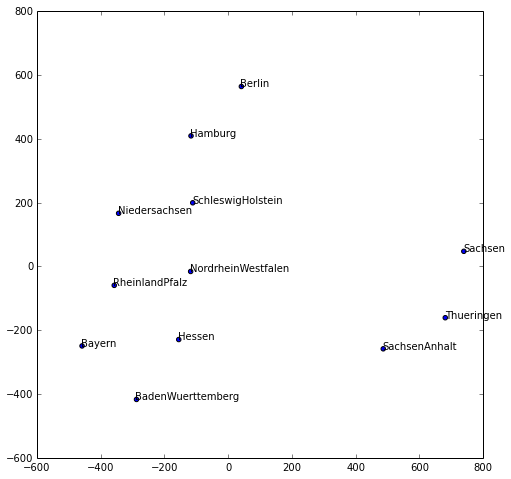

In [ ]:
tsne = manifold.TSNE(init='pca', random_state=0, method='exact')
Y = tsne.fit_transform(german_states_embedding)
states_names = ['Niedersachsen', 'Hamburg', 'Thueringen', 'RheinlandPfalz', 'SachsenAnhalt', 'BadenWuerttemberg','Sachsen', 'Berlin', 'Hessen', 'SchleswigHolstein', 'Bayern', 'NordrheinWestfalen']
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(states_names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]))
plt.savefig('state_embedding.png')

<img src="https://github.com/huynguyen12019/KHDLUD-k18-nhom06-entity-embedding-rossmann/blob/main/Karte-Deutschland-Fun-Facts-Deutsch.png?raw=1">

##### Các thứ trong tuần (dayofweek)

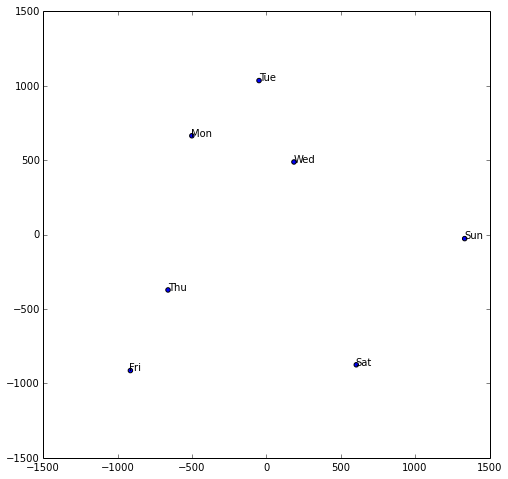

In [ ]:
tsne = manifold.TSNE(init='pca', random_state=0, method='exact')
Y = tsne.fit_transform(dow_embedding)
names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun']
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]))
plt.savefig('dow_embedding.png')

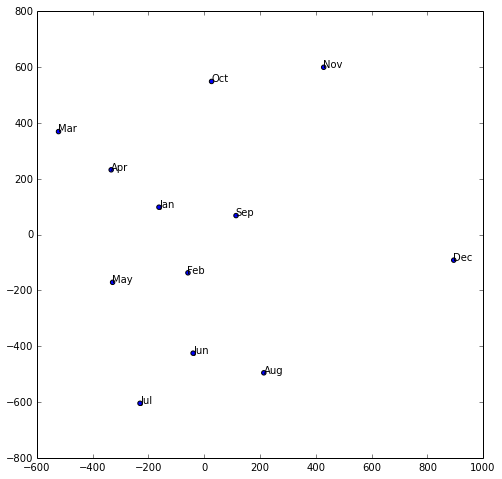

In [ ]:
tsne = manifold.TSNE(init='pca', random_state=0, method='exact')
Y = tsne.fit_transform(month_embedding)
names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]))
plt.savefig('month_embedding.png')

##### Mối quan hệ giữa các cửa hàng (store id)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1115
[t-SNE] Computed conditional probabilities for sample 1115 / 1115
[t-SNE] Mean sigma: 0.556386
[t-SNE] Iteration 25: error = 1.8772213, gradient norm = 0.0088505
[t-SNE] Iteration 50: error = 1.8653208, gradient norm = 0.0117393
[t-SNE] Iteration 75: error = 1.6902087, gradient norm = 0.0017479
[t-SNE] Iteration 100: error = 1.6649340, gradient norm = 0.0023789
[t-SNE] Error after 100 iterations with early exaggeration: 1.664934
[t-SNE] Iteration 125: error = 1.6263980, gradient norm = 0.0009421
[t-SNE] Iteration 150: error = 1.6151983, gradient norm = 0.0011778
[t-SNE] Iteration 175: error = 1.6138413, gradient norm = 0.0024398
[t-SNE] Iteration 200: error = 1.6169428, gradient norm = 0.0027734
[t-SNE] Iteration 225: error = 1.6150642, gradient norm = 0.0026934
[t-SNE] Iteration 250: error = 1.6154118, gradient norm = 0.0026828
[t-SNE] Iteration 250: did not make any progress duri

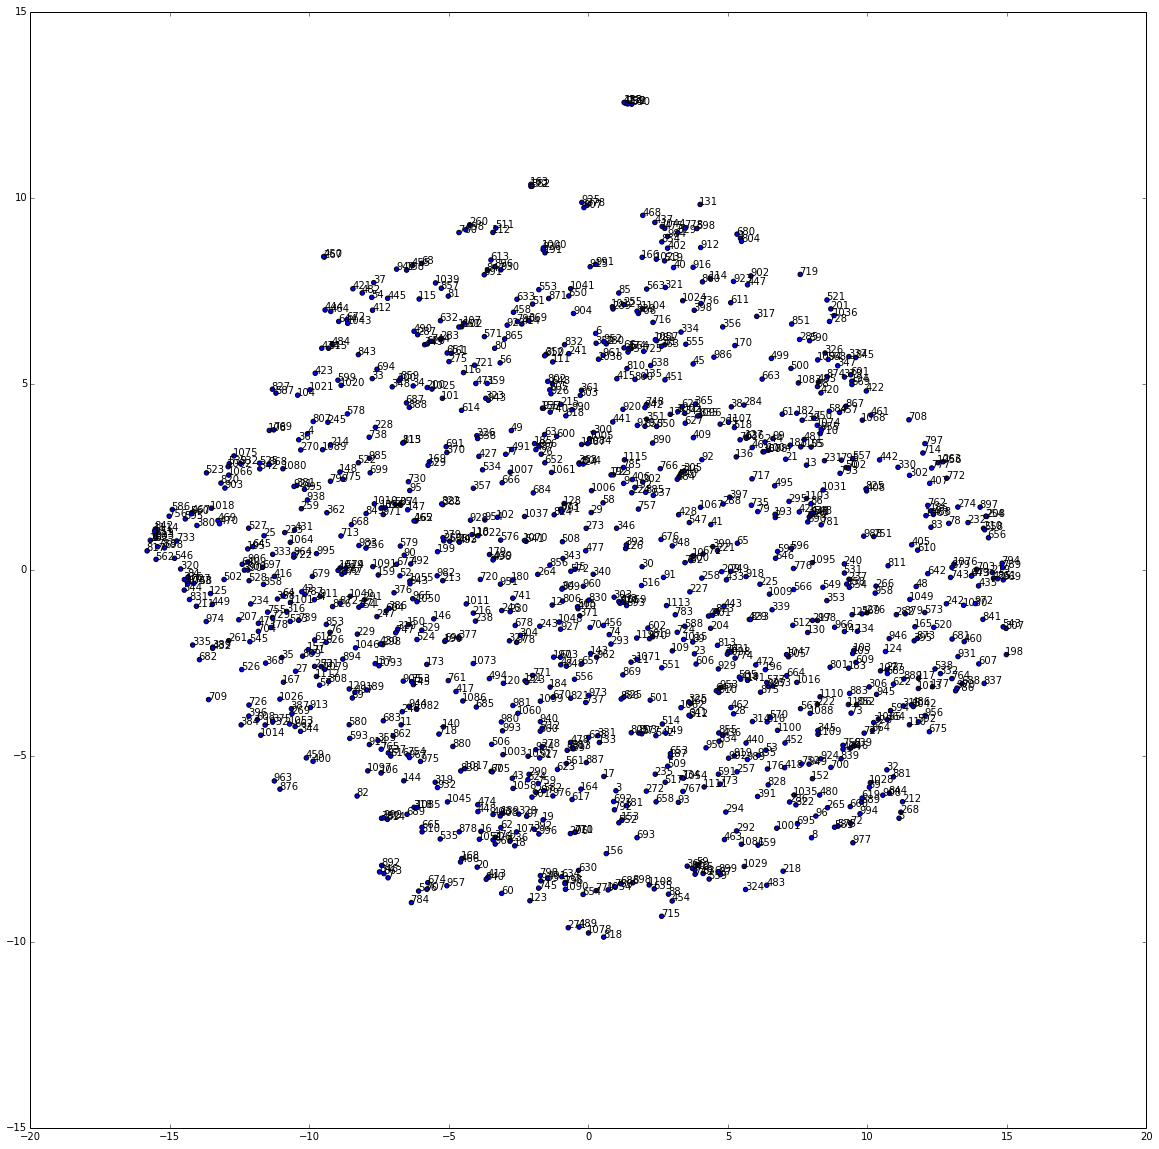

In [ ]:
tsne = manifold.TSNE(init='pca', random_state=0, method='exact', learning_rate=500, verbose=2, early_exaggeration=1)
Y = tsne.fit_transform(store_embedding)
names = [str(i) for i in range(1, 1116)]
plt.figure(figsize=(20,20))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]))
plt.savefig('store_embedding.png')